# 1D kinematic driver with time-dependent aerosol injection

Author: Jatan Buch (v1, 240424) || (v2, 240429)

In [1]:
from case_files.settings_time import Settings 
from case_files.simulation_time import Simulation
import numpy as np
import xarray
from tqdm import tqdm

from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from utils.plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/impl_numba/conf.py:19: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


## Case setup

In [2]:
common_params = {
    "t_max": 60 * si.minutes,
    "n_sd_per_mode": (32,),
    "aerosol_modes_by_kappa": {
            .3: Lognormal(
                        norm_factor= 10 / si.cm ** 3,
                        m_mode= 1E2 * si.nm,
                        s_geom=1.4
                ),
            },
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 990 * si.hPa,
    "z_part": ((0., 1.),),
    "n_seed_sds": 1, #no. of seed SDs per simulation time step (dt)
    "r_seed": 1 * si.um,
    "kappa_seed": 0.85,
    "m_param": 1e8,
    "seed_z_part": (0., 0.25),
    "t_part": (19* si.minutes, 24* si.minutes) #time period for SD injection
}

### sandbox

In [3]:
output = {}
settings = {}
simulation = {}
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

key = f"rhow={rho_times_w}"
settings[key] = Settings(
        **common_params,
        formulae= Formulae(seed= np.random.randint(1000)),
        rho_times_w_1=rho_times_w,
        precip= True
        )
simulation[key] = Simulation(settings[key])
output[key] = simulation[key].run().products

rain_xarr = {}
rain_xarr[key]= xarray.DataArray(data= output[key]['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key]['t'],),
                                z=(["z"], output[key]['z'],),)
                            )

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


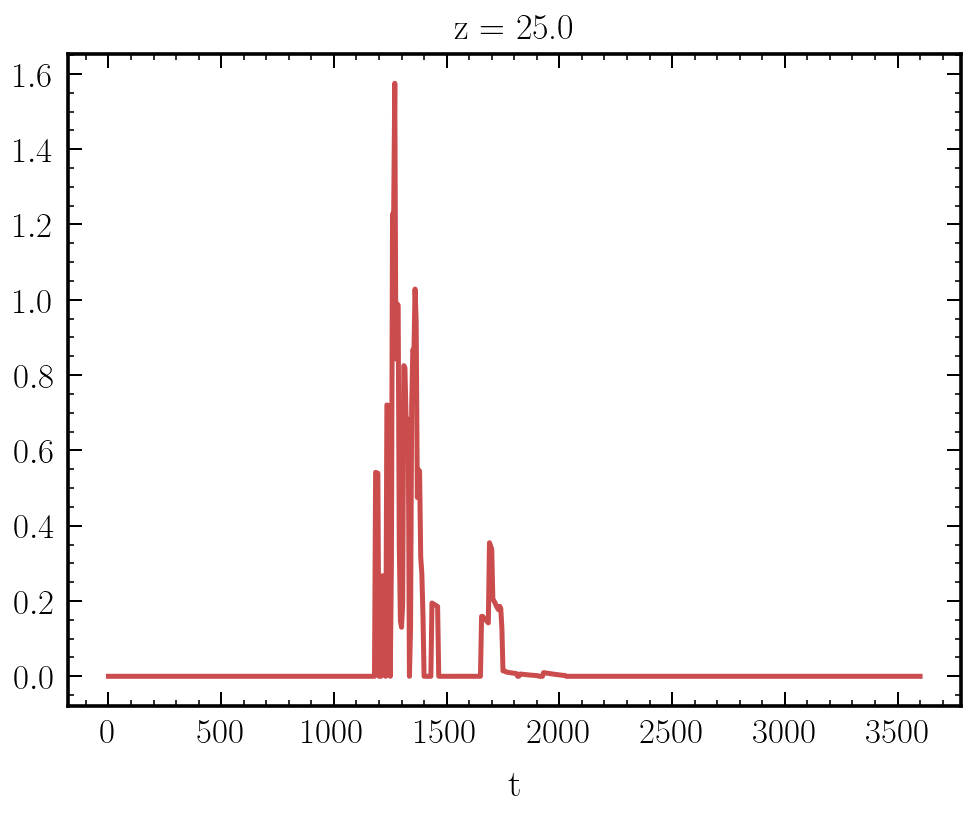

In [4]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
rain_xarr[key].sel(z= 25).plot(ax= ax)

In [5]:
# number of SDs as well as the idx are updated to include the new seed SDs
simulation['rhow=2.0'].particulator.n_sd, simulation['rhow=2.0'].particulator.attributes.get_idx().data.shape

(2396, (2396,))

In [6]:
# no collision coalescence since multiplicities remain unchanged for seed SDs
np.count_nonzero(simulation['rhow=2.0'].particulator.attributes['multiplicity'].data == settings[key].m_param)

60

In [7]:
# no displacement as positions remain unchanged for seed SDs; 
# init_poscell is calculated at the end of seeding and final_poscell is calculated at the end of the simulation
np.count_nonzero(simulation['rhow=2.0'].init_poscell == simulation['rhow=2.0'].final_poscell)  

58

In [8]:
simulation['rhow=2.0'].init_poscell

array([1.56662026e-001, 7.26537577e-001, 9.98374837e+157, 5.19231588e+250,
       1.07995490e+071, 5.32650660e-001, 2.94112073e-001, 7.33945402e-001,
       9.99942074e-001, 8.74314653e-001, 8.72466638e-001, 1.05251709e-002,
       8.33037704e-001, 2.55700853e+062, 4.05560930e-001, 4.28376646e-002,
       3.57412408e-001, 7.10642254e-001, 7.10642254e-001, 1.31928252e-001,
       8.25045863e-001, 9.99942074e-001, 9.77068420e-001, 1.12700665e-001,
       1.36477116e-001, 8.20211715e-001, 7.10642254e-001, 4.52053860e-001,
       8.72466638e-001, 5.32650660e-001, 9.77068420e-001, 1.36477116e-001,
       2.44328375e-001, 8.52633593e-001, 1.12700665e-001, 3.22150701e-001,
                   nan,             nan, 5.61853107e-001, 7.26537577e-001,
       4.24889509e-002, 3.57412408e-001, 3.55488832e-001, 8.72545567e-001,
       2.60318957e-001, 6.99556106e-001, 8.72466638e-001, 4.52053860e-001,
       4.28376646e-002, 5.32650660e-001, 9.77383791e-001, 6.93052268e-001,
       2.60318957e-001, 7

### Stochastic averaging

In [7]:
output = {}
settings = {}
simulation = {}
rain_xarr = {}
cloud_xarr= {}
surface_rain= {}
surface_cloud= {}

np.random.seed(91)
n_runs= 5
rho_times_w_arr= np.array([2]) * si.kg/si.m**3 * si.m/si.s
sav_flag= True

for r_id in tqdm(range(n_runs)):
    for rho_times_w in (rho_times_w_arr):
        key = f"rhow={rho_times_w}_run={r_id}"
        settings[key] = Settings(
            **common_params,
            formulae= Formulae(seed= np.random.randint(1000)),
            rho_times_w_1=rho_times_w,
            precip= True
            )
        simulation[key] = Simulation(settings[key])
        output[key] = simulation[key].run().products
            
        rain_xarr[key]= xarray.DataArray(data= output[key]['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key]['t'],),
                                z=(["z"], output[key]['z'],),)
                            )

for rho_times_w in (rho_times_w_arr):
    key = f"rhow={rho_times_w}"
    surface_rain[key]= xarray.concat([rain_xarr[key + "_run=" + str(i)] for i in range(n_runs)], dim="run")
    surface_rain[key]= surface_rain[key].assign_coords(run=range(n_runs))

if sav_flag:
    surface_rain[key].to_netcdf("../../sav_files/surface_rain_" + key + "_n1_10_r1_0.1_nsdbkg_32_m6_nsd_32_rsd_0.1_zseed_0.25_tseed_20_30.nc")

  0%|          | 0/5 [00:00<?, ?it/s]

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
100%|██████████| 5/5 [17:09<00:00, 205.96s/it]


## Plotting

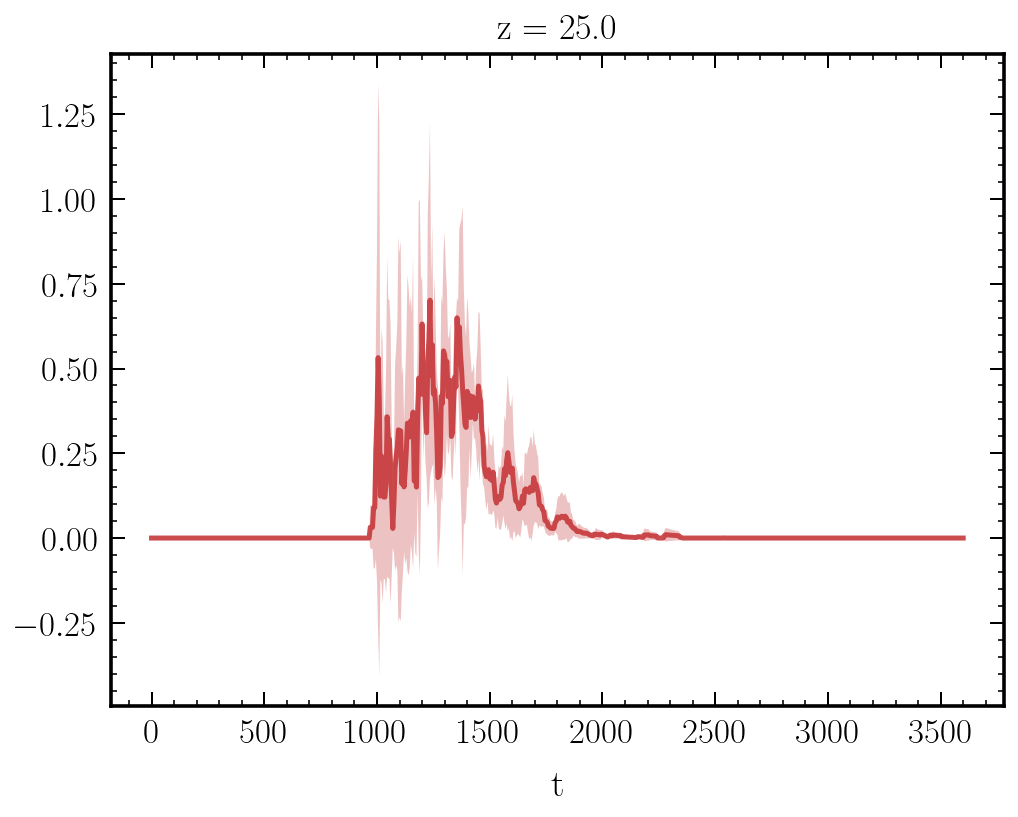

In [8]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain[key].sel(z= 25).mean(dim= "run").plot(ax= ax)
ax.fill_between(surface_rain[key].t, surface_rain[key].sel(z= 25).mean(dim= "run") + surface_rain[key].sel(z= 25).std(dim= "run"), \
                                        surface_rain[key].sel(z= 25).mean(dim= "run") - surface_rain[key].sel(z= 25).std(dim= "run"), alpha= 0.3)

In [9]:
surface_rain_alt= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_10_r1_0.1_nsd_32.nc")
surface_rain_nsd_2040= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_10_r1_0.1_nsdbkg_32_m6_nsd_32_rsd_0.1_zseed_0.25_tseed_20_30.nc")
#surface_rain_nsd_4050= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_50_r1_0.1_n2_10_r2_1_nsdbkg_32_m9_nsd_32_zseed_0.25_tseed_40_50.nc")

In [10]:
surface_rain_nsd_2040.sel(z= 25).mean(dim= "run").sum()

<xarray.DataArray ()>
array(44.54671445)
Coordinates:
    z        float64 25.0

In [11]:
surface_rain_alt.sel(z= 25).mean(dim= "run").sum()

<xarray.DataArray ()>
array(87.87408869)
Coordinates:
    z        float64 25.0

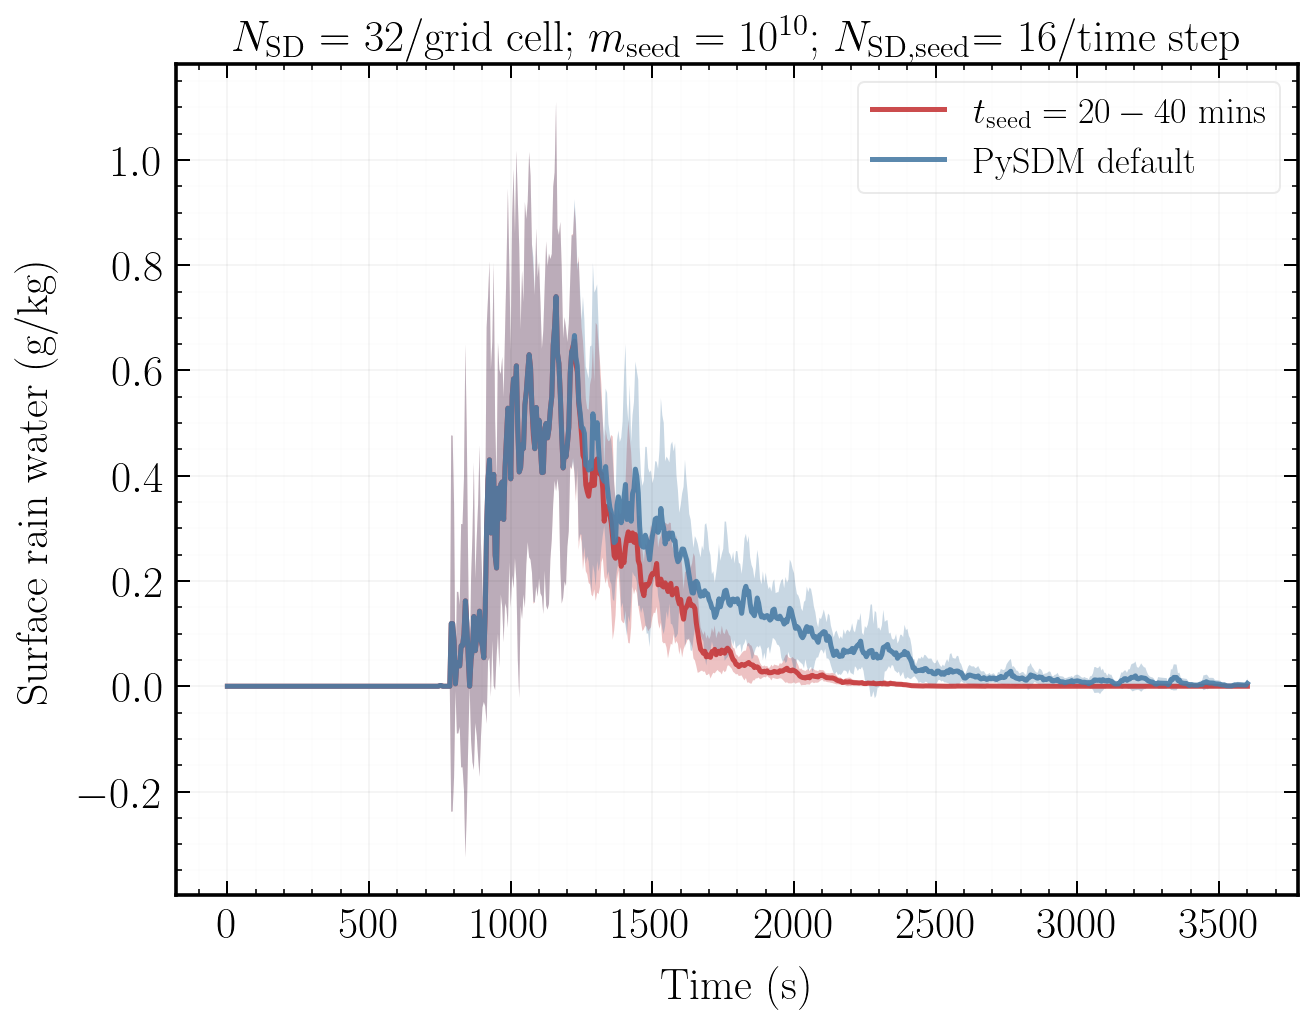

In [11]:
fig, ax= plt.subplots(1, 1, figsize= (9, 7) , constrained_layout= True)
surface_rain_nsd_2040.sel(z= 25).mean(dim= "run").plot(ax= ax, label= r'$t_{\rm seed} = 20 - 40$ mins')
#surface_rain_nsd_4050.sel(z= 25).mean(dim= "run").plot(ax= ax, label= r'$t_{\rm seed} = 40 - 50$ mins')
surface_rain_alt.sel(z= 25).mean(dim= "run").plot(ax= ax, label= 'PySDM default')
ax.fill_between(surface_rain_nsd_2040.t, surface_rain_nsd_2040.sel(z= 25).mean(dim= "run") + surface_rain_nsd_2040.sel(z= 25).std(dim= "run"), \
                                        surface_rain_nsd_2040.sel(z= 25).mean(dim= "run") - surface_rain_nsd_2040.sel(z= 25).std(dim= "run"), alpha= 0.3)
#ax.fill_between(surface_rain_nsd_4050.t, surface_rain_nsd_4050.sel(z= 25).mean(dim= "run") + surface_rain_nsd_4050.sel(z= 25).std(dim= "run"), \
#                                        surface_rain_nsd_4050.sel(z= 25).mean(dim= "run") - surface_rain_nsd_4050.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.fill_between(surface_rain_alt.t, surface_rain_alt.sel(z= 25).mean(dim= "run") + surface_rain_alt.sel(z= 25).std(dim= "run"), \
                                        surface_rain_alt.sel(z= 25).mean(dim= "run") - surface_rain_alt.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Surface rain water (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

ax.set_title(r'$N_{\rm SD}$ = 32/grid cell; $m_{\rm seed}= 10^{10}$; $N_{\rm SD, seed}$= 16/time step', fontsize= 22);
#ax.set_title(r'$\rho_w \times w = 2$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.savefig('../../plots/surface_rain_water_n1_10_n2_1_r2_1_m10_rsd_10_tpart_plot.pdf', bbox_inches='tight', dpi= 300);

In [16]:
settings['rhow=2.0_run=0'].dz **2

2500.0

In [18]:
1e9/5 * 32 /(settings['rhow=2.0_run=0'].dz **2 * 1E4)

256.0